# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd "/content/drive/MyDrive/week4/weeklyproject/helper_utils.py"

[Errno 20] Not a directory: '/content/drive/MyDrive/week4/weeklyproject/helper_utils.py'
/content/drive/MyDrive/week4


In [3]:
!pwd
!ls


/content/drive/MyDrive/week4
weeklyproject


In [4]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image

import kagglehub


In [12]:
import sys

sys.path.append("/content/drive/MyDrive/week4/weeklyproject")


In [13]:
import helper_utils


## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [14]:

import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


CUDA available: True
Device: cuda


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [16]:
import os
import kagglehub

data_path = kagglehub.dataset_download(
    "puneet6060/intel-image-classification"
)

print("Dataset path:", data_path)
print("Root contents:", os.listdir(data_path))


Using Colab cache for faster access to the 'intel-image-classification' dataset.
Dataset path: /kaggle/input/intel-image-classification
Root contents: ['seg_train', 'seg_pred', 'seg_test']


In [17]:
import os, random

pred_dir = os.path.join(data_path, "seg_pred", "seg_pred")
print("Files:", os.listdir(pred_dir)[:5])


Files: ['6234.jpg', '22288.jpg', '20529.jpg', '21440.jpg', '5982.jpg']


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

> Add blockquote



In [18]:
from torchvision import datasets

train_dir = os.path.join(data_path, "seg_train", "seg_train")
test_dir  = os.path.join(data_path, "seg_test", "seg_test")

train_dataset = datasets.ImageFolder(root=train_dir)
test_dataset  = datasets.ImageFolder(root=test_dir)

print("Classes:", train_dataset.classes)


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [19]:
print("Number of training images:", len(train_dataset))
print("Number of testing images:", len(test_dataset))


Number of training images: 14034
Number of testing images: 3000


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [20]:
from torchvision import transforms


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [21]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torch
import os

full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_transform)

val_ratio = 0.2
train_size = int((1 - val_ratio) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


full_train_dataset.transform = val_transform

val_dataset = torch.utils.data.Subset(full_train_dataset, val_dataset.indices)

full_train_dataset.transform = train_transform
train_dataset = torch.utils.data.Subset(full_train_dataset, train_dataset.indices)

batch_size =  64
num_workers = 0
pin_memory = False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))


Train: 11227 Val: 2807 Test: 3000


**Quick Check**: Visualize a batch of training images

In [22]:
helper_utils.visualize_batch?

In [23]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([64, 3, 224, 224]) torch.Size([64])


In [24]:
class_names = full_train_dataset.classes
print(class_names)



['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


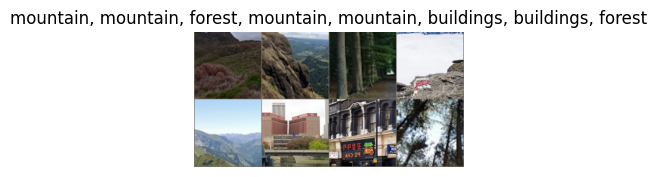

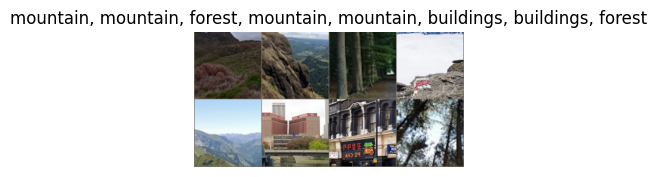

In [26]:
import helper_utils
helper_utils.visualize_batch(train_loader, class_names, num_images=8, figsize=(3, 6))



Images batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


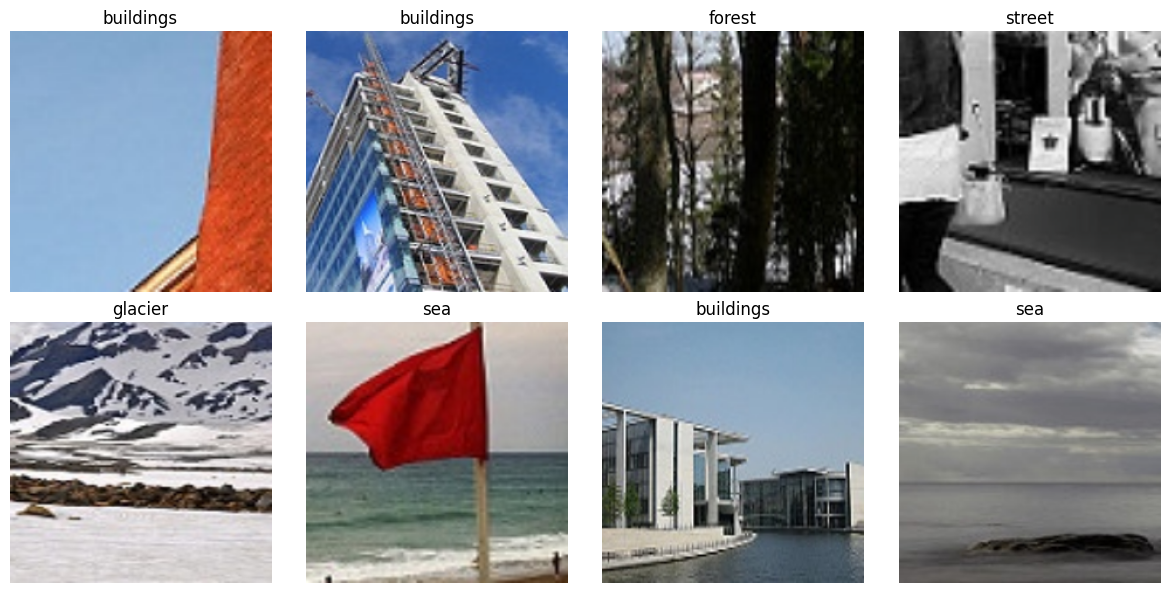

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch


images, labels = next(iter(train_loader))
print("Images batch shape:", images.shape)
print("Labels batch shape:", labels.shape)

mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
std  = torch.tensor(IMAGENET_STD).view(3, 1, 1)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    img = images[i].cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    axes[i].imshow(np.clip(img, 0, 1))
    axes[i].set_title(full_train_dataset.classes[labels[i].item()])
    axes[i].axis("off")

plt.tight_layout()
plt.show()


<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [28]:
import torch
import torch.nn as nn
from torchvision import models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = 6

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

print(model)
print("Final layer:", model.fc)


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_acc = 0
    best_w = {k: v.clone() for k, v in model.state_dict().items()}

    for e in range(epochs):
        model.train()
        tloss, tcorrect = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            tloss += loss.item() * x.size(0)
            tcorrect += (out.argmax(1) == y).sum().item()

        tloss /= len(train_loader.dataset)
        tacc = tcorrect / len(train_loader.dataset)

        model.eval()
        vloss, vcorrect = 0, 0
        with torch.inference_mode():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                vloss += loss.item() * x.size(0)
                vcorrect += (out.argmax(1) == y).sum().item()

        vloss /= len(val_loader.dataset)
        vacc = vcorrect / len(val_loader.dataset)

        history["train_loss"].append(tloss)
        history["train_acc"].append(tacc)
        history["val_loss"].append(vloss)
        history["val_acc"].append(vacc)

        print(f"Epoch {e+1}/{epochs} | train_acc={tacc:.3f} val_acc={vacc:.3f}")

        if vacc > best_acc:
            best_acc = vacc
            best_w = {k: v.clone() for k, v in model.state_dict().items()}

    model.load_state_dict(best_w)
    return model, history



<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [31]:
from torchvision import models

num_classes = 6

model_conv = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_conv.fc = nn.Linear(model_conv.fc.in_features, num_classes)
model_conv = model_conv.to(device)

print(model_conv.fc)


Linear(in_features=512, out_features=6, bias=True)


In [38]:
for p in model_conv.parameters():
    p.requires_grad = True




In [40]:
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(
    model_conv.parameters(),
    lr=1e-4
)


In [41]:
epochs = 5
model_conv, history_conv = train_model(
    model_conv, train_loader, val_loader,
    criterion, optimizer_conv, device,
    epochs=epochs
)


Epoch 1/5 | train_acc=0.898 val_acc=0.880
Epoch 2/5 | train_acc=0.909 val_acc=0.901
Epoch 3/5 | train_acc=0.915 val_acc=0.896
Epoch 4/5 | train_acc=0.921 val_acc=0.906
Epoch 5/5 | train_acc=0.926 val_acc=0.904


**Quick Check**: Visualize training history

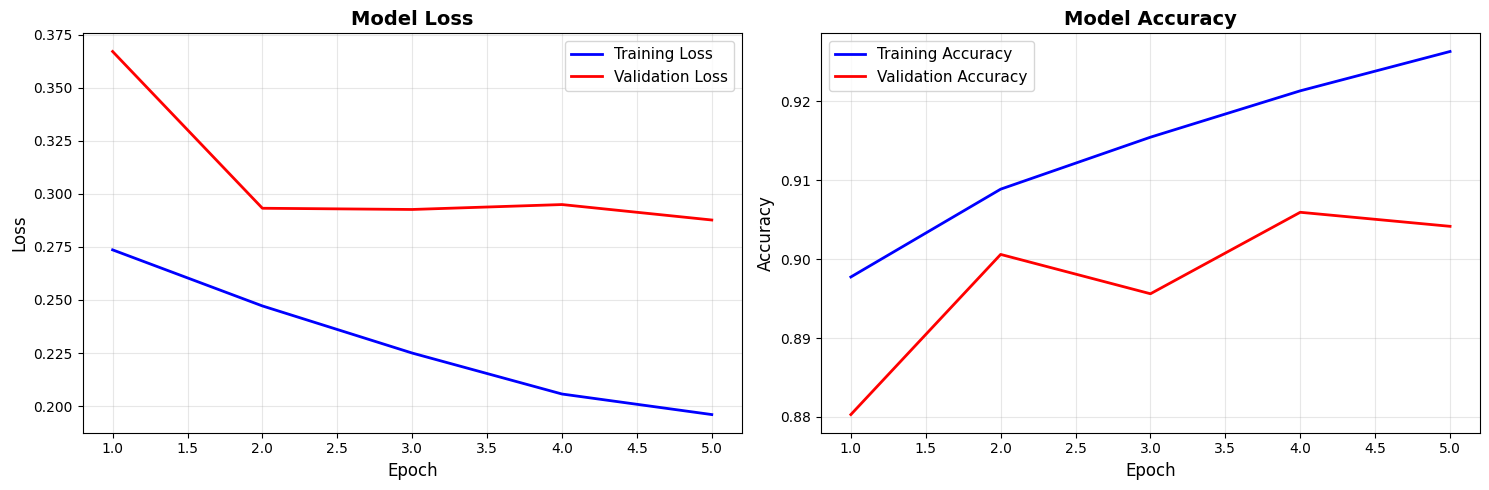

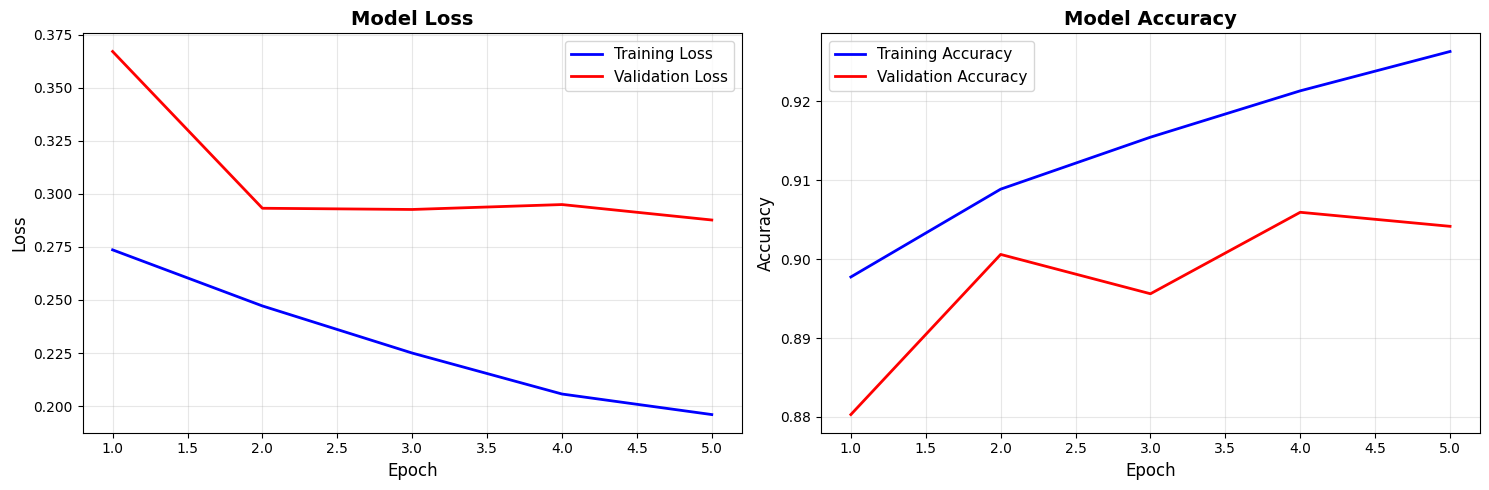

In [42]:
helper_utils.visualize_training_history(history_conv)


**Quick Check**: Visualize predictions

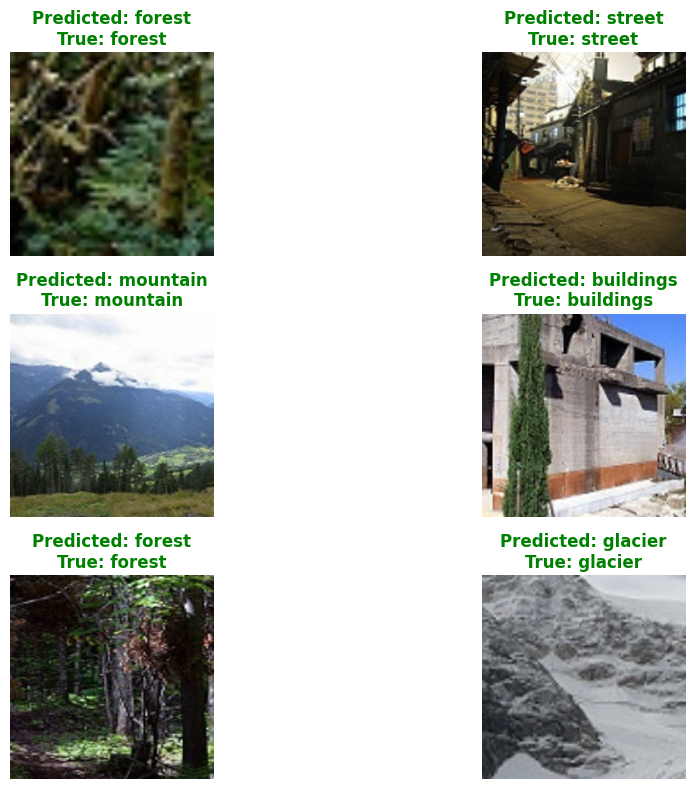

In [43]:
helper_utils.visualize_predictions(model_conv, val_loader, class_names, device, num_images=6)
plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [44]:
from torchvision import models
import torch.nn as nn

num_classes = 6

model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
model_ft = model_ft.to(device)

print(model_ft.fc)


Linear(in_features=512, out_features=6, bias=True)


In [45]:
for p in model_ft.parameters():
    p.requires_grad = True


In [46]:
criterion_ft = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)


In [47]:
epochs = 5

model_ft, history_ft = train_model(
    model_ft, train_loader, val_loader,
    criterion_ft, optimizer_ft, device,
    epochs=epochs
)


Epoch 1/5 | train_acc=0.849 val_acc=0.889
Epoch 2/5 | train_acc=0.891 val_acc=0.897
Epoch 3/5 | train_acc=0.898 val_acc=0.907
Epoch 4/5 | train_acc=0.909 val_acc=0.891
Epoch 5/5 | train_acc=0.913 val_acc=0.902


**Quick Check**: Visualize training history

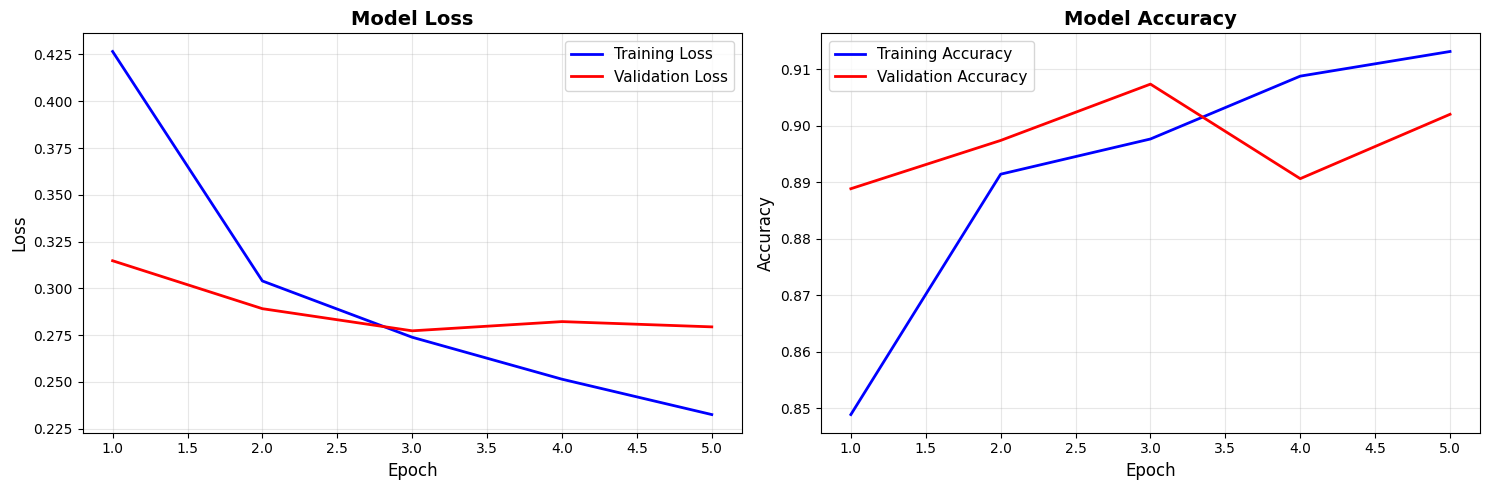

In [48]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

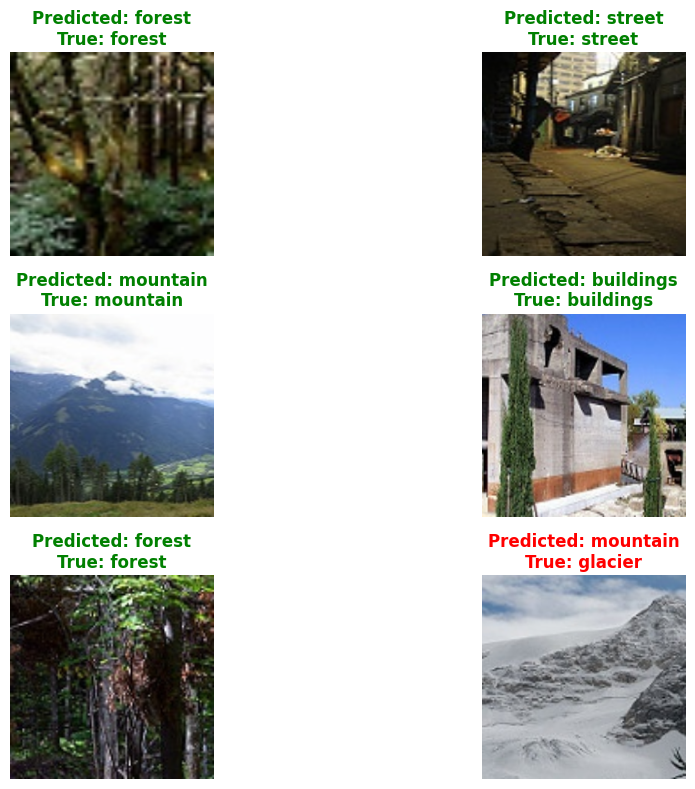

In [50]:
helper_utils.visualize_predictions(model_ft, val_loader, class_names, device, num_images=6)
plt.show()

In [51]:
model_ft = model_ft.to(device)


In [53]:
import torch

def eval_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [54]:
test_acc = eval_accuracy(model_ft, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9280


<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [55]:
import time
import torch

def eval_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

val_acc_conv_eval = eval_accuracy(model_conv, val_loader, device)
val_acc_ft_eval   = eval_accuracy(model_ft,   val_loader, device)

print("Feature Extractor Approach (Conv Frozen, FC Trained):")
print(f"  Best Val Accuracy (history):  {max(history_conv['val_acc']):.4f}")
print(f"  Final Val Accuracy (history): {history_conv['val_acc'][-1]:.4f}")
print(f"  Val Accuracy (re-eval):       {val_acc_conv_eval:.4f}")
print()

print("Fine-tuning Approach (All Layers Trainable):")
print(f"  Best Val Accuracy (history):  {max(history_ft['val_acc']):.4f}")
print(f"  Final Val Accuracy (history): {history_ft['val_acc'][-1]:.4f}")
print(f"  Val Accuracy (re-eval):       {val_acc_ft_eval:.4f}")


Feature Extractor Approach (Conv Frozen, FC Trained):
  Best Val Accuracy (history):  0.9059
  Final Val Accuracy (history): 0.9042
  Val Accuracy (re-eval):       0.8892

Fine-tuning Approach (All Layers Trainable):
  Best Val Accuracy (history):  0.9074
  Final Val Accuracy (history): 0.9020
  Val Accuracy (re-eval):       0.8974


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

In [56]:
img_path = os.path.join(pred_dir, random.choice(os.listdir(pred_dir)))
print("Image path:", img_path)



Image path: /kaggle/input/intel-image-classification/seg_pred/seg_pred/24046.jpg


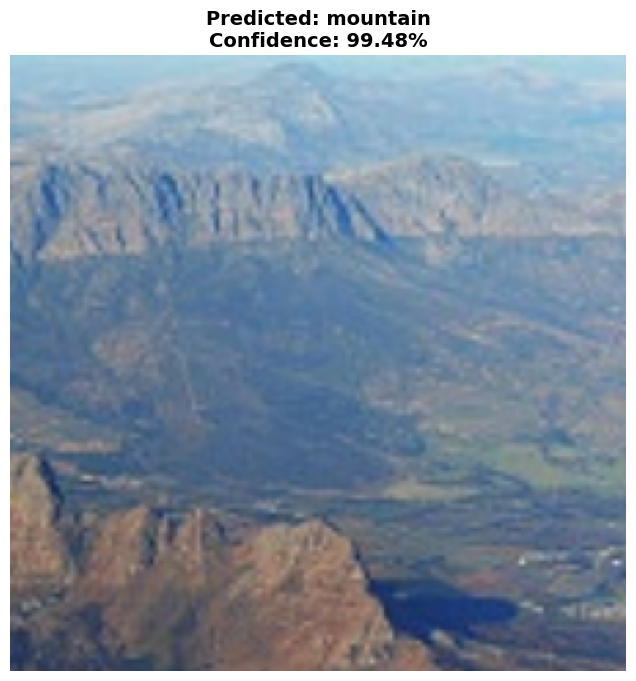

In [57]:
import matplotlib.pyplot as plt

helper_utils.visualize_single_prediction(
    model_ft,
    img_path,
    val_transform,
    class_names,
    device
)

plt.show()


# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [58]:
!pip install -q onnx onnxscript


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 14.3 MB/s eta 0:00:00


In [59]:
import torch

model_ft_cpu = model_ft.to("cpu")
model_ft_cpu.eval()

dummy_input = torch.randn(1, 3, 224, 224)

onnx_path = "model_ft.onnx"

torch.onnx.export(
    model_ft_cpu,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=12,
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

print(f"Model exported to {onnx_path}")


/tmp/ipython-input-4197844138.py:10: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0110 10:00:51.936000 1532 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 12 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
Model exported to model_ft.onnx


In [60]:
!pip install -q onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 130.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.2 MB/s eta 0:00:00


In [61]:
!pwd
!ls


/content/drive/MyDrive/week4
model_ft.onnx  model_ft.onnx.data  weeklyproject


In [62]:

import onnxruntime as ort
import numpy as np
from PIL import Image
import os, random

onnx_path = "model_ft.onnx"
ort_session = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

pred_dir = os.path.join(data_path, "seg_pred", "seg_pred")
img_path = os.path.join(pred_dir, random.choice(os.listdir(pred_dir)))
print("Test image:", img_path)

img = Image.open(img_path).convert('RGB')
img_tensor = val_transform(img).unsqueeze(0)
img_numpy = img_tensor.numpy().astype(np.float32)

input_name = ort_session.get_inputs()[0].name
outputs = ort_session.run(None, {input_name: img_numpy})

predictions = np.array(outputs[0])
pred_class_idx = np.argmax(predictions[0])
pred_class = class_names[pred_class_idx]

exp = np.exp(predictions - predictions.max(axis=1, keepdims=True))
probs = exp / exp.sum(axis=1, keepdims=True)
confidence = float(probs[0, pred_class_idx])

print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")



Test image: /kaggle/input/intel-image-classification/seg_pred/seg_pred/13972.jpg
Predicted: forest (confidence: 100.00%)


In [63]:
!ls -lh model_ft.onnx


-rw------- 1 root root 87K Jan 10 10:00 model_ft.onnx


##Conclusion
In this project, a ResNet-18 model was trained for image classification using transfer learning. Fine-tuning the model achieved strong performance, with a validation accuracy of about 90.7% and a test accuracy of 92.8%. The trained model was also successfully exported to ONNX format for deployment, confirming its effectiveness and usability.